# Intro Scalable Deep Learning: Day 5, Tutorial 1

- **Content creators**: Mehdi Cherti
- **Content reviewers**: Jan Ebert, Jenia Jitsev
- **Content supervisors**: Mehdi Cherti
_________________

The original source of this tutorial is from: https://www.tensorflow.org/tutorials/generative/dcgan. Most of the credits go to them.

## Tutorial Objectives

In this tutorial, you will learn how to:

- Train a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN), which consists of a convolutional network-based **generator** and **discriminator**.
- Distribute the training using Horovod's [DistributedGradientTape](https://horovod.readthedocs.io/en/stable/api.html#horovod.tensorflow.DistributedGradientTape) wrapper for the [gradient tapes](https://www.tensorflow.org/api_docs/python/tf/GradientTape?version=nightly)

## Intro

[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in machine learning today. A model attempting to implicitly estimate data probability density is trained in an unsupervised manner from data samples by using two different networks simultaneously in an adversarial interplay process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes as generated by the *generator* network.

![A diagram of a generator and discriminator](images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](./images/gan2.png)

The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)


## Setup

In [3]:
import glob
from pathlib import Path
import time

import imageio
from IPython import display
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

def load_mnist():
    path = '/p/project/training2306/datasets/MNIST/mnist.npz'
    with np.load(path, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

## Section 1: Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
(train_images, train_labels), (_, _) = load_mnist()

In [5]:
# Pixel intensities are between 0 and 255
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
# We do this because the final activation function we are going
# to use on the generator (tanh) is also defined on this interval.
train_images = (train_images - 127.5) / 127.5

In [6]:
print(train_images.shape)

(60000, 28, 28, 1)


In [7]:
BUFFER_SIZE = 60000  # Buffer size for shuffling
BATCH_SIZE = 256

In [17]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Section 2: Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from random noise. Start with a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer that takes this noise as input, then upsample several times until you reach the desired image size of 28×28×1. Notice the [tf.keras.layers.LeakyReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses tanh.

In [19]:
def make_generator_model(input_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(input_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # `None` is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as of yet untrained) generator to create an image.

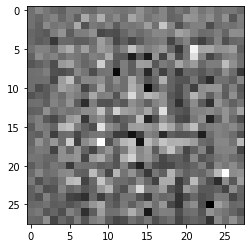

In [20]:
generator_input_size = 100
generator = make_generator_model(generator_input_size)

noise = tf.random.normal([1, generator_input_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

Use the (as of yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output 1 for real images, and 0 for fake images.

In [22]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00124445]], shape=(1, 1), dtype=float32)


## Section 3: Define the loss and optimizers

Define loss functions and optimizers for both models.

In [23]:
# Create a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [27]:
checkpoint_dir = Path('./training_checkpoints')
checkpoint_prefix = checkpoint_dir / 'ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Section 4: Define the training loop

In [28]:
EPOCHS = 100
num_examples_to_generate = 16

# We will reuse this noise overtime (so it's easier
# to visualize progress in the animated GIF).
fixed_noise = tf.random.normal([num_examples_to_generate, generator_input_size])

The training loop begins with the generator receiving random noise as input. That noise is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [29]:
# Notice the use of `@tf.function`.
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, generator_input_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [8]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 fixed_noise)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=str(checkpoint_prefix.expanduser()))

        print ('Time for epoch {} is {} secs'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             fixed_noise)

**Generate and save images**

In [31]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to `False`.
    # This is so all layers run in inference mode
    # which is relevant for batch normalization.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Here we do an inverse normalization to get the outputs
        # from the generator to resemble image data.
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Section 5: Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not "overpower" each other (e.g. that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(str(checkpoint_dir.expanduser())))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Generate a single image from the last checkpoint.

In [ ]:
noise = tf.random.normal([1, generator_input_size])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
display.Image(anim_file)

# Exercises

The code above only trains the model using a single GPU. The goal of the exercise is to use
Horovod to train the code in multiple nodes and GPUs. In `dcgan_multi_node.py` there is
a similar version of the code in the notebook where we train on CIFAR-10 instead of MNIST, but you need to modify it to use Horovod.

- Fill the missing parts (please check all the **TODO** comments) of `dcgan_multi_node.py` to use Horovod
- Run the code by running `sbatch run.sh`
- Visualize the generated images in by rendering `image_at_epoch_***.png` files.

# Summary

In this tutorial, we have seen how train a [DCGAN architecture](https://arxiv.org/pdf/1511.06434.pdf) and use Horovod to distribute the training across nodes. While the effect of large (effective) batch sizes on the performance is still not as well studied in the GAN literature as in classical supervised learning tasks, we have evidence from works such as BigGAN ([Brock et al.](https://arxiv.org/abs/1809.11096)) that large batch sizes are helpful for stabilizing training and helping the generator cover more modes (BigGAN used an effective batch size of 2048).